In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pprint
import math
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from prophet import Prophet
import optuna #optimisation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


In [2]:
df = pd.read_csv('cars_washington_processed cleaned completely.csv')
df

,Clean Alternative Fuel Vehicle Type,VIN (1-10),DOL Vehicle ID,Model Year,Make,Model,Vehicle Primary Use,Electric Range,Odometer Reading,Odometer Code,New or Used Vehicle,Sale Price,Sale Date,Base MSRP,Transaction Type,DOL Transaction Date,Transaction Year,County,City,State of Residence
0,Battery Electric Vehicle (BEV),JN1AZ0CP6B,101926373,2011,NISSAN,Leaf,Passenger,73,5,Actual Mileage,New,0.000000,2011-02-28,0,Original Title,April 19 2011,2011,King,SEATTLE,WA
1,Battery Electric Vehicle (BEV),JN1AZ0CP6B,101926373,2011,NISSAN,Leaf,Passenger,73,5,Actual Mileage,New,0.000000,2011-02-28,0,Original Registration,April 19 2011,2011,King,SEATTLE,WA
2,Plug-in Hybrid Electric Vehicle (PHEV),YV4H60CXXP,244884517,2023,VOLVO,XC90,Passenger,32,0,Odometer reading is not collected at time of r...,New,78334.445087,2023-03-07,0,Original Registration,July 18 2023,2023,King,BOTHELL,WA
3,Plug-in Hybrid Electric Vehicle (PHEV),YV4H60CXXP,244884517,2023,VOLVO,XC90,Passenger,32,10,Actual Mileage,New,85545.000000,2023-06-24,0,Original Title,July 18 2023,2023,King,BOTHELL,WA
4,Battery Electric Vehicle (BEV),7SAXCBE54P,229752386,2023,TESLA,Model X,Passenger,0,0,Odometer reading is not collected at time of r...,New,109050.457692,2023-06-24,0,Original Registration,February 17 2023,2023,King,KIRKLAND,WA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
832173,Battery Electric Vehicle (BEV),7SAYGDEF4N,202878826,2022,TESLA,Model Y,Passenger,0,0,Odometer reading is not collected at time of r...,Used,47462.144300,2023-08-18,0,Registration Renewal,May 16 2023,2023,Hillsborough,TAMPA,FL
832174,Battery Electric Vehicle (BEV),5YJ3E1EC8P,220999229,2023,TESLA,Model 3,Passenger,0,0,Odometer reading is not collected at time of r...,Used,36140.248783,2023-08-26,0,Registration Renewal,September 21 2023,2023,Snohomish,LAKE STEVENS,WA
832175,Battery Electric Vehicle (BEV),KNDC3DLCXN,220351918,2022,KIA,EV6,Passenger,0,0,Odometer reading is not collected at time of r...,Used,45415.405063,2023-08-26,0,Registration Renewal,September 20 2023,2023,Pierce,PUYALLUP,WA
832176,Battery Electric Vehicle (BEV),5YJSA1E50N,253247942,2022,TESLA,Model S,Passenger,0,0,Odometer reading is not collected at time of r...,Used,40330.762821,2023-08-26,0,Original Registration,September 13 2023,2023,Snohomish,LYNNWOOD,WA


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 832178 entries, 0 to 832177
Data columns (total 20 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   Clean Alternative Fuel Vehicle Type  832178 non-null  object 
 1   VIN (1-10)                           832178 non-null  object 
 2   DOL Vehicle ID                       832178 non-null  int64  
 3   Model Year                           832178 non-null  int64  
 4   Make                                 832178 non-null  object 
 5   Model                                832178 non-null  object 
 6   Vehicle Primary Use                  832178 non-null  object 
 7   Electric Range                       832178 non-null  int64  
 8   Odometer Reading                     832178 non-null  int64  
 9   Odometer Code                        832178 non-null  object 
 10  New or Used Vehicle                  832178 non-null  object 
 11  Sale Price   

In [4]:
df['Sale Date'] = pd.to_datetime(df['Sale Date'])

In [5]:
new_vehicles_df = df[df['New or Used Vehicle'] == 'New']
used_vehicles_df = df[df['New or Used Vehicle'] == 'Used'] 

In [6]:
new_vehicles_df = new_vehicles_df[new_vehicles_df['Sale Price'] != 0]
used_vehicles_df = used_vehicles_df[used_vehicles_df['Sale Price'] != 0]

In [7]:
new_vehicles_df.head()

,Clean Alternative Fuel Vehicle Type,VIN (1-10),DOL Vehicle ID,Model Year,Make,Model,Vehicle Primary Use,Electric Range,Odometer Reading,Odometer Code,New or Used Vehicle,Sale Price,Sale Date,Base MSRP,Transaction Type,DOL Transaction Date,Transaction Year,County,City,State of Residence
2,Plug-in Hybrid Electric Vehicle (PHEV),YV4H60CXXP,244884517,2023,VOLVO,XC90,Passenger,32,0,Odometer reading is not collected at time of r...,New,78334.445087,2023-03-07,0,Original Registration,July 18 2023,2023,King,BOTHELL,WA
3,Plug-in Hybrid Electric Vehicle (PHEV),YV4H60CXXP,244884517,2023,VOLVO,XC90,Passenger,32,10,Actual Mileage,New,85545.000000,2023-06-24,0,Original Title,July 18 2023,2023,King,BOTHELL,WA
4,Battery Electric Vehicle (BEV),7SAXCBE54P,229752386,2023,TESLA,Model X,Passenger,0,0,Odometer reading is not collected at time of r...,New,109050.457692,2023-06-24,0,Original Registration,February 17 2023,2023,King,KIRKLAND,WA
5,Battery Electric Vehicle (BEV),7SAXCBE54P,229752386,2023,TESLA,Model X,Passenger,0,15,Actual Mileage,New,120130.000000,2023-01-20,0,Original Title,February 17 2023,2023,King,KIRKLAND,WA
6,Battery Electric Vehicle (BEV),5YJ3E1EB8L,104750334,2020,TESLA,Model 3,Passenger,322,50,Actual Mileage,New,52190.000000,2020-03-05,0,Original Title,March 31 2020,2020,King,SEATTLE,WA


In [8]:
used_vehicles_df.head()

,Clean Alternative Fuel Vehicle Type,VIN (1-10),DOL Vehicle ID,Model Year,Make,Model,Vehicle Primary Use,Electric Range,Odometer Reading,Odometer Code,New or Used Vehicle,Sale Price,Sale Date,Base MSRP,Transaction Type,DOL Transaction Date,Transaction Year,County,City,State of Residence
310004,Battery Electric Vehicle (BEV),5YJSA1DP6D,137019942,2013,TESLA,Model S,Passenger,208,26629,Actual Mileage,Used,65979.323944,2016-03-31,69900,Registration at time of Transfer,May 25 2016,2016,King,SEATTLE,WA
310005,Battery Electric Vehicle (BEV),5YJSA1DP1D,239433008,2013,TESLA,Model S,Passenger,208,0,Odometer reading is not collected at time of r...,Used,65979.323944,2016-03-31,69900,Registration Renewal,July 29 2020,2020,King,SEATTLE,WA
310006,Battery Electric Vehicle (BEV),5YJSA1H14E,149926332,2014,TESLA,Model S,Passenger,208,20032,Actual Mileage,Used,65979.323944,2016-07-25,69900,Transfer Title,August 05 2016,2016,King,SEATTLE,WA
310009,Battery Electric Vehicle (BEV),5YJSA1H13E,265063424,2014,TESLA,Model S,Passenger,208,30510,Actual Mileage,Used,65979.323944,2016-03-21,69900,Transfer Title,March 24 2016,2016,King,SEATTLE,WA
310010,Battery Electric Vehicle (BEV),5YJSA1CN4D,145079833,2013,TESLA,Model S,Passenger,208,31292,Actual Mileage,Used,65979.323944,2016-06-22,69900,Transfer Title,June 28 2016,2016,King,SEATTLE,WA


In [9]:
# Create a dictionary for store the average Sale Price of by Year(Sale Date) for each Make and Model of New Cars

grouped_new = new_vehicles_df.groupby([new_vehicles_df['Sale Date'].dt.year, 'Make', 'Model'])['Sale Price'].mean().reset_index()

average_sale_prices_new = {}

for index, row in grouped_new.iterrows():
    year = row['Sale Date']
    make = row['Make']
    model = row['Model']
    avg_price = row['Sale Price']
    
    if year not in average_sale_prices_new:
        average_sale_prices_new[year] = {}
    
    if make not in average_sale_prices_new[year]:
        average_sale_prices_new[year][make] = {}
    
    average_sale_prices_new[year][make][model] = avg_price
    
# Create a dictionary for store the average Sale Price of by Year(Sale Date) for each Make and Model of New Cars
    
grouped_used = used_vehicles_df.groupby([used_vehicles_df['Sale Date'].dt.year, 'Make', 'Model'])['Sale Price'].mean().reset_index()

average_sale_prices_used = {}

for index, row in grouped_used.iterrows():
    year = row['Sale Date']
    make = row['Make']
    model = row['Model']
    avg_price = row['Sale Price']
    
    if year not in average_sale_prices_used:
        average_sale_prices_used[year] = {}
    
    if make not in average_sale_prices_used[year]:
        average_sale_prices_used[year][make] = {}
    
    average_sale_prices_used[year][make][model] = avg_price

In [10]:
year = 2016
make = 'AUDI'
model = 'A3'

avg_price = average_sale_prices_used[year][make][model]
print(f"The average sale price of {make} {model} in {year} was ${avg_price:.2f}")

The average sale price of AUDI A3 in 2016 was $33838.33


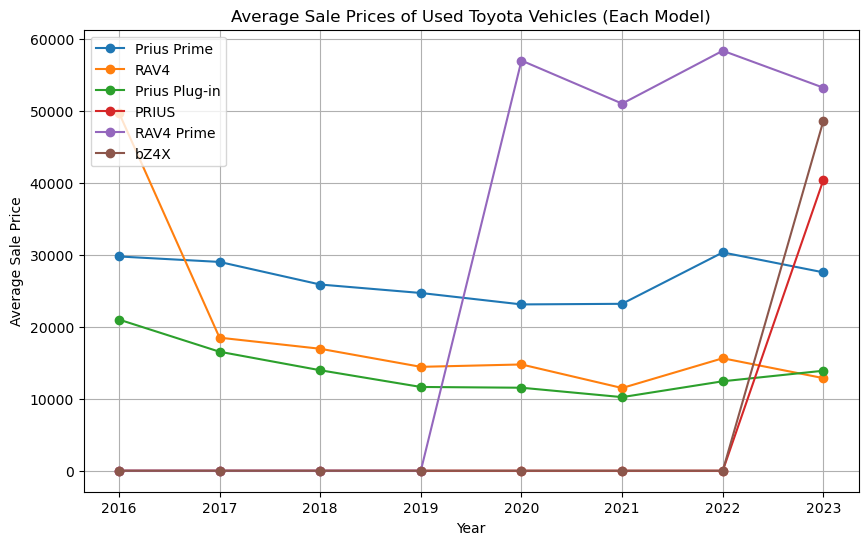

In [11]:
toyota_years = sorted(year for year in average_sale_prices_used if 'TOYOTA' in average_sale_prices_used[year])

# Get the Toyota models
toyota_models = set()
for year in toyota_years:
    if 'TOYOTA' in average_sale_prices_used[year]:
        toyota_models.update(average_sale_prices_used[year]['TOYOTA'].keys())

# Plotting separate lines for each Toyota model
plt.figure(figsize=(10, 6))
for model in toyota_models:
    model_avg_prices = [average_sale_prices_used[year]['TOYOTA'].get(model, 0) for year in toyota_years]
    plt.plot(toyota_years, model_avg_prices, marker='o', label=model)

plt.title('Average Sale Prices of Used Toyota Vehicles (Each Model)')
plt.xlabel('Year')
plt.ylabel('Average Sale Price')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
new_vehicles_df = df[df['New or Used Vehicle'] == 'New']
used_vehicles_df = df[df['New or Used Vehicle'] == 'Used'] 


In [13]:
new_vehicles_df

,Clean Alternative Fuel Vehicle Type,VIN (1-10),DOL Vehicle ID,Model Year,Make,Model,Vehicle Primary Use,Electric Range,Odometer Reading,Odometer Code,New or Used Vehicle,Sale Price,Sale Date,Base MSRP,Transaction Type,DOL Transaction Date,Transaction Year,County,City,State of Residence
0,Battery Electric Vehicle (BEV),JN1AZ0CP6B,101926373,2011,NISSAN,Leaf,Passenger,73,5,Actual Mileage,New,0.000000,2011-02-28,0,Original Title,April 19 2011,2011,King,SEATTLE,WA
1,Battery Electric Vehicle (BEV),JN1AZ0CP6B,101926373,2011,NISSAN,Leaf,Passenger,73,5,Actual Mileage,New,0.000000,2011-02-28,0,Original Registration,April 19 2011,2011,King,SEATTLE,WA
2,Plug-in Hybrid Electric Vehicle (PHEV),YV4H60CXXP,244884517,2023,VOLVO,XC90,Passenger,32,0,Odometer reading is not collected at time of r...,New,78334.445087,2023-03-07,0,Original Registration,July 18 2023,2023,King,BOTHELL,WA
3,Plug-in Hybrid Electric Vehicle (PHEV),YV4H60CXXP,244884517,2023,VOLVO,XC90,Passenger,32,10,Actual Mileage,New,85545.000000,2023-06-24,0,Original Title,July 18 2023,2023,King,BOTHELL,WA
4,Battery Electric Vehicle (BEV),7SAXCBE54P,229752386,2023,TESLA,Model X,Passenger,0,0,Odometer reading is not collected at time of r...,New,109050.457692,2023-06-24,0,Original Registration,February 17 2023,2023,King,KIRKLAND,WA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309997,Battery Electric Vehicle (BEV),1N4AZ1BV7P,253381040,2023,NISSAN,Leaf,Passenger,0,41,Actual Mileage,New,29438.000000,2023-09-01,0,Original Title,September 14 2023,2023,King,SEATTLE,WA
309998,Battery Electric Vehicle (BEV),1N4AZ1BV7P,253381040,2023,NISSAN,Leaf,Passenger,0,0,Odometer reading is not collected at time of r...,New,32759.130751,2023-09-01,0,Original Registration,September 14 2023,2023,King,SEATTLE,WA
309999,Battery Electric Vehicle (BEV),7FCTGAAAXP,253561990,2023,RIVIAN,R1T,Truck,0,100,Actual Mileage,New,77400.000000,2023-08-26,0,Original Title,September 21 2023,2023,King,SEATTLE,WA
310000,Battery Electric Vehicle (BEV),7FCTGAAAXP,253561990,2023,RIVIAN,R1T,Truck,0,0,Odometer reading is not collected at time of r...,New,84648.814545,2023-08-26,0,Original Registration,September 21 2023,2023,King,SEATTLE,WA


In [14]:
used_vehicles_df

,Clean Alternative Fuel Vehicle Type,VIN (1-10),DOL Vehicle ID,Model Year,Make,Model,Vehicle Primary Use,Electric Range,Odometer Reading,Odometer Code,New or Used Vehicle,Sale Price,Sale Date,Base MSRP,Transaction Type,DOL Transaction Date,Transaction Year,County,City,State of Residence
310002,Battery Electric Vehicle (BEV),5YJSA1CN4D,281040350,2013,TESLA,Model S,Passenger,208,15500,Actual Mileage,Used,0.000000,2015-07-16,69900,Registration Renewal,November 29 2016,2016,King,SEATTLE,WA
310003,Battery Electric Vehicle (BEV),5YJSA1H17E,190417853,2014,TESLA,Model S,Passenger,208,16331,Actual Mileage,Used,0.000000,2015-07-16,69900,Transfer Title,August 27 2015,2015,King,SEATTLE,WA
310004,Battery Electric Vehicle (BEV),5YJSA1DP6D,137019942,2013,TESLA,Model S,Passenger,208,26629,Actual Mileage,Used,65979.323944,2016-03-31,69900,Registration at time of Transfer,May 25 2016,2016,King,SEATTLE,WA
310005,Battery Electric Vehicle (BEV),5YJSA1DP1D,239433008,2013,TESLA,Model S,Passenger,208,0,Odometer reading is not collected at time of r...,Used,65979.323944,2016-03-31,69900,Registration Renewal,July 29 2020,2020,King,SEATTLE,WA
310006,Battery Electric Vehicle (BEV),5YJSA1H14E,149926332,2014,TESLA,Model S,Passenger,208,20032,Actual Mileage,Used,65979.323944,2016-07-25,69900,Transfer Title,August 05 2016,2016,King,SEATTLE,WA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
832173,Battery Electric Vehicle (BEV),7SAYGDEF4N,202878826,2022,TESLA,Model Y,Passenger,0,0,Odometer reading is not collected at time of r...,Used,47462.144300,2023-08-18,0,Registration Renewal,May 16 2023,2023,Hillsborough,TAMPA,FL
832174,Battery Electric Vehicle (BEV),5YJ3E1EC8P,220999229,2023,TESLA,Model 3,Passenger,0,0,Odometer reading is not collected at time of r...,Used,36140.248783,2023-08-26,0,Registration Renewal,September 21 2023,2023,Snohomish,LAKE STEVENS,WA
832175,Battery Electric Vehicle (BEV),KNDC3DLCXN,220351918,2022,KIA,EV6,Passenger,0,0,Odometer reading is not collected at time of r...,Used,45415.405063,2023-08-26,0,Registration Renewal,September 20 2023,2023,Pierce,PUYALLUP,WA
832176,Battery Electric Vehicle (BEV),5YJSA1E50N,253247942,2022,TESLA,Model S,Passenger,0,0,Odometer reading is not collected at time of r...,Used,40330.762821,2023-08-26,0,Original Registration,September 13 2023,2023,Snohomish,LYNNWOOD,WA


In [15]:
for index, row in new_vehicles_df.iterrows():
    if row['Sale Price'] == 0:
        year = row['Sale Date'].year
        make = row['Make']
        model = row['Model']
        if year in average_sale_prices_new and make in average_sale_prices_new[year] and model in average_sale_prices_new[year][make]:
            new_vehicles_df.at[index, 'Sale Price'] = average_sale_prices_new[year][make][model]

# Replace zero sale prices in used_vehicles_df
for index, row in used_vehicles_df.iterrows():
    if row['Sale Price'] == 0:
        year = row['Sale Date'].year
        make = row['Make']
        model = row['Model']
        if year in average_sale_prices_used and make in average_sale_prices_used[year] and model in average_sale_prices_used[year][make]:
            used_vehicles_df.at[index, 'Sale Price'] = average_sale_prices_used[year][make][model]

In [16]:
new_vehicles_df

,Clean Alternative Fuel Vehicle Type,VIN (1-10),DOL Vehicle ID,Model Year,Make,Model,Vehicle Primary Use,Electric Range,Odometer Reading,Odometer Code,New or Used Vehicle,Sale Price,Sale Date,Base MSRP,Transaction Type,DOL Transaction Date,Transaction Year,County,City,State of Residence
0,Battery Electric Vehicle (BEV),JN1AZ0CP6B,101926373,2011,NISSAN,Leaf,Passenger,73,5,Actual Mileage,New,0.000000,2011-02-28,0,Original Title,April 19 2011,2011,King,SEATTLE,WA
1,Battery Electric Vehicle (BEV),JN1AZ0CP6B,101926373,2011,NISSAN,Leaf,Passenger,73,5,Actual Mileage,New,0.000000,2011-02-28,0,Original Registration,April 19 2011,2011,King,SEATTLE,WA
2,Plug-in Hybrid Electric Vehicle (PHEV),YV4H60CXXP,244884517,2023,VOLVO,XC90,Passenger,32,0,Odometer reading is not collected at time of r...,New,78334.445087,2023-03-07,0,Original Registration,July 18 2023,2023,King,BOTHELL,WA
3,Plug-in Hybrid Electric Vehicle (PHEV),YV4H60CXXP,244884517,2023,VOLVO,XC90,Passenger,32,10,Actual Mileage,New,85545.000000,2023-06-24,0,Original Title,July 18 2023,2023,King,BOTHELL,WA
4,Battery Electric Vehicle (BEV),7SAXCBE54P,229752386,2023,TESLA,Model X,Passenger,0,0,Odometer reading is not collected at time of r...,New,109050.457692,2023-06-24,0,Original Registration,February 17 2023,2023,King,KIRKLAND,WA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309997,Battery Electric Vehicle (BEV),1N4AZ1BV7P,253381040,2023,NISSAN,Leaf,Passenger,0,41,Actual Mileage,New,29438.000000,2023-09-01,0,Original Title,September 14 2023,2023,King,SEATTLE,WA
309998,Battery Electric Vehicle (BEV),1N4AZ1BV7P,253381040,2023,NISSAN,Leaf,Passenger,0,0,Odometer reading is not collected at time of r...,New,32759.130751,2023-09-01,0,Original Registration,September 14 2023,2023,King,SEATTLE,WA
309999,Battery Electric Vehicle (BEV),7FCTGAAAXP,253561990,2023,RIVIAN,R1T,Truck,0,100,Actual Mileage,New,77400.000000,2023-08-26,0,Original Title,September 21 2023,2023,King,SEATTLE,WA
310000,Battery Electric Vehicle (BEV),7FCTGAAAXP,253561990,2023,RIVIAN,R1T,Truck,0,0,Odometer reading is not collected at time of r...,New,84648.814545,2023-08-26,0,Original Registration,September 21 2023,2023,King,SEATTLE,WA


In [17]:
used_vehicles_df

,Clean Alternative Fuel Vehicle Type,VIN (1-10),DOL Vehicle ID,Model Year,Make,Model,Vehicle Primary Use,Electric Range,Odometer Reading,Odometer Code,New or Used Vehicle,Sale Price,Sale Date,Base MSRP,Transaction Type,DOL Transaction Date,Transaction Year,County,City,State of Residence
310002,Battery Electric Vehicle (BEV),5YJSA1CN4D,281040350,2013,TESLA,Model S,Passenger,208,15500,Actual Mileage,Used,0.000000,2015-07-16,69900,Registration Renewal,November 29 2016,2016,King,SEATTLE,WA
310003,Battery Electric Vehicle (BEV),5YJSA1H17E,190417853,2014,TESLA,Model S,Passenger,208,16331,Actual Mileage,Used,0.000000,2015-07-16,69900,Transfer Title,August 27 2015,2015,King,SEATTLE,WA
310004,Battery Electric Vehicle (BEV),5YJSA1DP6D,137019942,2013,TESLA,Model S,Passenger,208,26629,Actual Mileage,Used,65979.323944,2016-03-31,69900,Registration at time of Transfer,May 25 2016,2016,King,SEATTLE,WA
310005,Battery Electric Vehicle (BEV),5YJSA1DP1D,239433008,2013,TESLA,Model S,Passenger,208,0,Odometer reading is not collected at time of r...,Used,65979.323944,2016-03-31,69900,Registration Renewal,July 29 2020,2020,King,SEATTLE,WA
310006,Battery Electric Vehicle (BEV),5YJSA1H14E,149926332,2014,TESLA,Model S,Passenger,208,20032,Actual Mileage,Used,65979.323944,2016-07-25,69900,Transfer Title,August 05 2016,2016,King,SEATTLE,WA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
832173,Battery Electric Vehicle (BEV),7SAYGDEF4N,202878826,2022,TESLA,Model Y,Passenger,0,0,Odometer reading is not collected at time of r...,Used,47462.144300,2023-08-18,0,Registration Renewal,May 16 2023,2023,Hillsborough,TAMPA,FL
832174,Battery Electric Vehicle (BEV),5YJ3E1EC8P,220999229,2023,TESLA,Model 3,Passenger,0,0,Odometer reading is not collected at time of r...,Used,36140.248783,2023-08-26,0,Registration Renewal,September 21 2023,2023,Snohomish,LAKE STEVENS,WA
832175,Battery Electric Vehicle (BEV),KNDC3DLCXN,220351918,2022,KIA,EV6,Passenger,0,0,Odometer reading is not collected at time of r...,Used,45415.405063,2023-08-26,0,Registration Renewal,September 20 2023,2023,Pierce,PUYALLUP,WA
832176,Battery Electric Vehicle (BEV),5YJSA1E50N,253247942,2022,TESLA,Model S,Passenger,0,0,Odometer reading is not collected at time of r...,Used,40330.762821,2023-08-26,0,Original Registration,September 13 2023,2023,Snohomish,LYNNWOOD,WA


In [18]:
# Marge two DataFrames (Used and New Vehicles) after replacing zero sale prices
merged_df = pd.concat([new_vehicles_df, used_vehicles_df])

# Exporting the merged DataFrame to a CSV file
merged_df.to_csv('cars_washington_processed_v1.csv', index=False)

In [19]:


# Assuming your DataFrame is named 'df'
# Convert 'Sale Date' column to datetime format
df['Sale Date'] = pd.to_datetime(df['Sale Date'])

# Create a new column for the month
df['Month'] = df['Sale Date'].dt.month

# Group by month and count the number of sales
monthly_sales = df.groupby('Month')['DOL Vehicle ID'].count()

# Display the result
print(monthly_sales)


Month
1     47635
2     50617
3     82915
4     57690
5     73474
6     93635
7     65338
8     77853
9     87582
10    56801
11    57151
12    81487
Name: DOL Vehicle ID, dtype: int64


In [20]:
#Plot the Time Series
# Convert 'Sale Date' column to datetime format
df['Sale Date'] = pd.to_datetime(df['Sale Date'])

# Create a new column for the year and month combination
df['YearMonth'] = df['Sale Date'].dt.strftime('%Y-%m')

# Group by year and month, count the number of sales
data = df.groupby('YearMonth')['DOL Vehicle ID'].count().reset_index()

# Rename columns for clarity
data.columns = ['Month', 'Sales']

# Display the result
print(data)


       Month  Sales
0    2008-10      3
1    2010-01      4
2    2010-02      5
3    2010-03      9
4    2010-04     27
..       ...    ...
160  2023-05  16860
161  2023-06  23005
162  2023-07  17487
163  2023-08  18754
164  2023-09   6271

[165 rows x 2 columns]


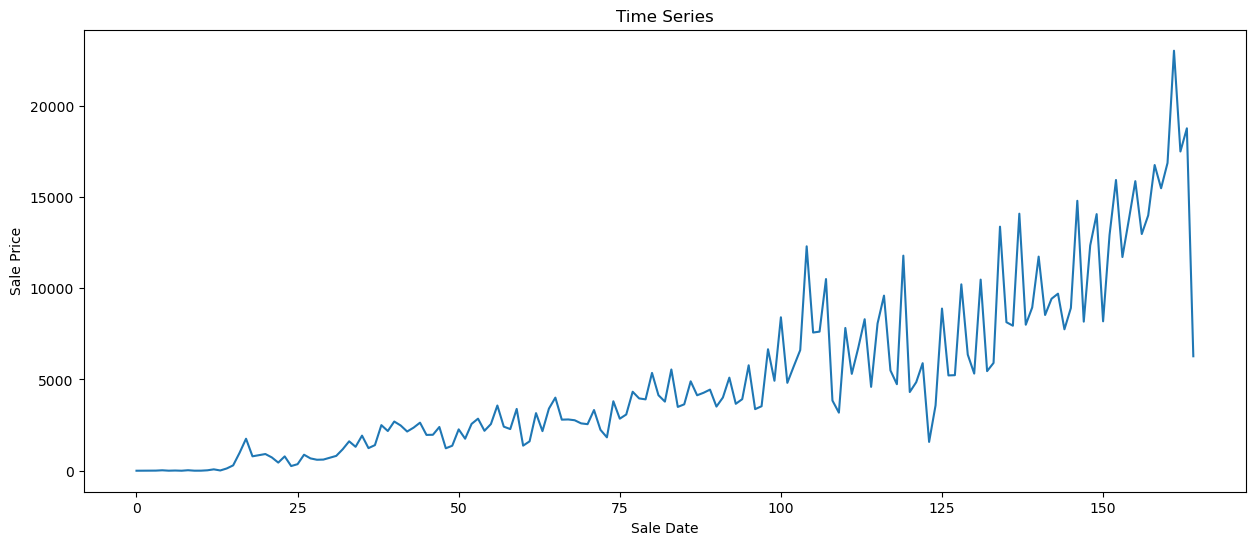

In [21]:

plt.figure(figsize=(15,6))
plt.plot(data.Sales)

plt.title('Time Series')
plt.xlabel('Sale Date')
plt.ylabel('Sale Price')
plt.show()

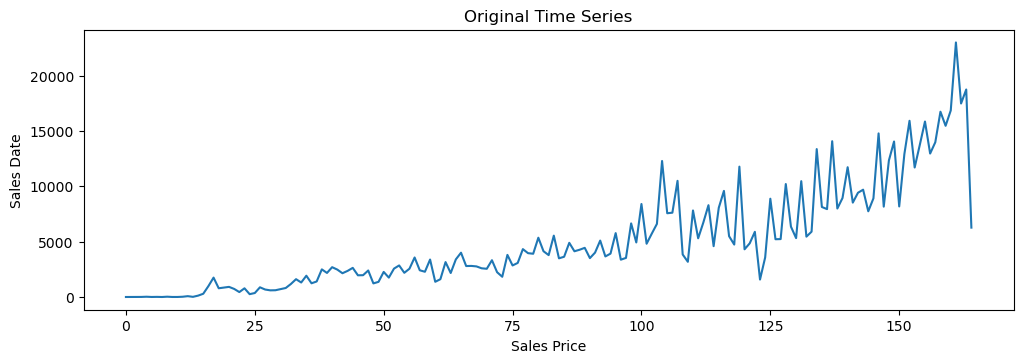

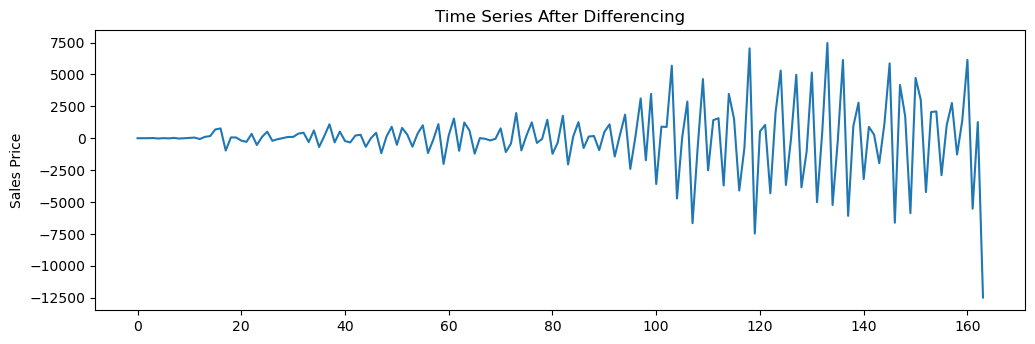

In [22]:
#Setting a Value for D to make the Time Series
d = 1

plt.figure(figsize=(12,8))
plt.subplot(211)
plt.plot(data.Sales)
plt.title('Original Time Series')
plt.xlabel('Sales Price')
plt.ylabel('Sales Date')
plt.show()

plt.figure(figsize=(12,8))
plt.subplot(212)

data_diff = data.Sales.diff(periods=d).values[d:]

plt.plot(data_diff)
plt.title('Time Series After Differencing')
plt.ylabel('Sales Price')
plt.show()

#d is set to 1, indicating that we are performing first-order differencing
#Differencing is a common technique used in time series analysis to stabilize the mean
# and eliminate trends or seasonality.

In [23]:
# CHOOSING p,q, P,D,Q, n using the ACF and PACF plots
data_diff


array([ 1.0000e+00,  1.0000e+00,  4.0000e+00,  1.8000e+01, -2.2000e+01,
        9.0000e+00, -1.1000e+01,  2.7000e+01, -2.5000e+01,  1.0000e+00,
        2.0000e+01,  5.2000e+01, -6.1000e+01,  1.0900e+02,  1.7000e+02,
        6.9000e+02,  7.6900e+02, -9.6300e+02,  6.5000e+01,  6.0000e+01,
       -1.8500e+02, -2.8400e+02,  3.4000e+02, -5.2900e+02,  1.0300e+02,
        5.1700e+02, -2.0100e+02, -7.4000e+01,  9.0000e+00,  1.0100e+02,
        1.0200e+02,  3.6200e+02,  4.3500e+02, -3.0000e+02,  6.1200e+02,
       -6.8400e+02,  1.6400e+02,  1.0950e+03, -3.2300e+02,  5.2000e+02,
       -2.1700e+02, -3.3000e+02,  2.1200e+02,  2.7300e+02, -6.7100e+02,
        8.0000e+00,  4.2600e+02, -1.1660e+03,  1.3900e+02,  8.9700e+02,
       -5.1200e+02,  8.1100e+02,  2.8700e+02, -6.6400e+02,  3.6900e+02,
        1.0150e+03, -1.1580e+03, -1.3200e+02,  1.1040e+03, -2.0110e+03,
        2.3400e+02,  1.5460e+03, -9.8600e+02,  1.2320e+03,  6.0300e+02,
       -1.2060e+03,  1.1000e+01, -4.4000e+01, -1.7100e+02, -4.30

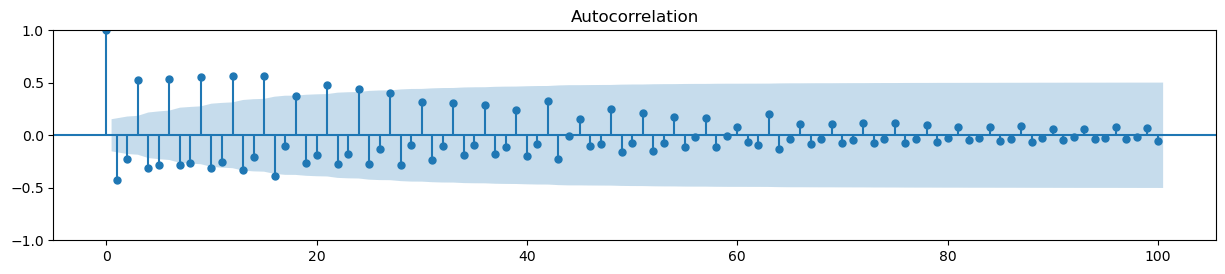

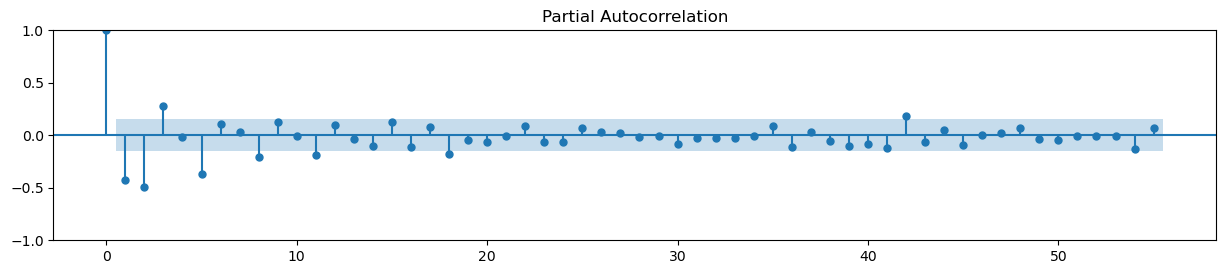

In [24]:
# Plot the ACF for the differenced series to choose p, q, P, Q
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(211)

#use of acf function
acf_graph = sm.graphics.tsa.plot_acf(data_diff, lags=100, ax=ax1)

fig = plt.figure(figsize=(15,6))
ax2 = fig.add_subplot(212)


# use pacf function
pacf_graph = sm.graphics.tsa.plot_pacf(data_diff, lags=55, ax=ax2)


#It looks like you are using the plot_acf and plot_pacf functions from the statsmodels library to analyze the autocorrelation and partial autocorrelation functions, respectively. 
#These plots help in determining the appropriate parameters for an ARIMA (AutoRegressive Integrated Moving Average) model.
#This code creates a subplot for the ACF plot with 100 lags. 
#The ACF plot shows the correlation between a time series and its lagged values.
# Peaks in the ACF plot indicate potential values for the parameter q in your ARIMA model.

#The PACF this code creates a subplot for the PACF plot with 55 lags. The PACF plot helps identify the direct relationship between a time series and its lagged values, assisting in determining the parameter p for your ARIMA model.

# this code creates a subplot for the PACF plot with 55 lags. The PACF plot helps identify the direct relationship between a time series and its lagged values, /n 
#assisting in determining the parameter p for your ARIMA model.
 
#After generating these plots, you should look for significant spikes or cutoff points in both the ACF and PACF plots. These can guide you in selecting appropriate values for the p and q parameters for your ARIMA model. Once you have determined these values, you can proceed with fitting the ARIMA model to your time series data.

In [25]:
#Build the Arima model using the chosen parameter values

p = 1
d = 1
q = 3
P = 0
D = 1
Q = 0
n = 12 

mod = sm.tsa.statespace.SARIMAX(data.Sales, trend='n', order=(p,d,q), seasonal_order=(P,D,Q,n), enforce_invertibility=False,
                               validate_specification=False)
results = mod.fit()

print(results.summary())


                                      SARIMAX Results                                      
Dep. Variable:                               Sales   No. Observations:                  165
Model:             SARIMAX(1, 1, 3)x(0, 1, [], 12)   Log Likelihood               -1369.430
Date:                             Thu, 14 Dec 2023   AIC                           2748.861
Time:                                     21:27:51   BIC                           2763.980
Sample:                                          0   HQIC                          2755.003
                                             - 165                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8350      0.103     -8.125      0.000      -1.036      -0.634
ma.L1          0.4230      

In [26]:
p = 1
d = 1
q = 3
P = 0
D = 1
Q = 0
n = 12 

mod = sm.tsa.statespace.SARIMAX(data.Sales, trend='n', order=(p,d,q), seasonal_order=(P,D,Q,n), enforce_invertibility=False,
                               validate_specification=False)
results = mod.fit()

print(results.summary())


                                      SARIMAX Results                                      
Dep. Variable:                               Sales   No. Observations:                  165
Model:             SARIMAX(1, 1, 3)x(0, 1, [], 12)   Log Likelihood               -1369.430
Date:                             Thu, 14 Dec 2023   AIC                           2748.861
Time:                                     21:27:51   BIC                           2763.980
Sample:                                          0   HQIC                          2755.003
                                             - 165                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8350      0.103     -8.125      0.000      -1.036      -0.634
ma.L1          0.4230      

Text(0.5, 1.0, 'Arima Forecast Model for 200 data points')

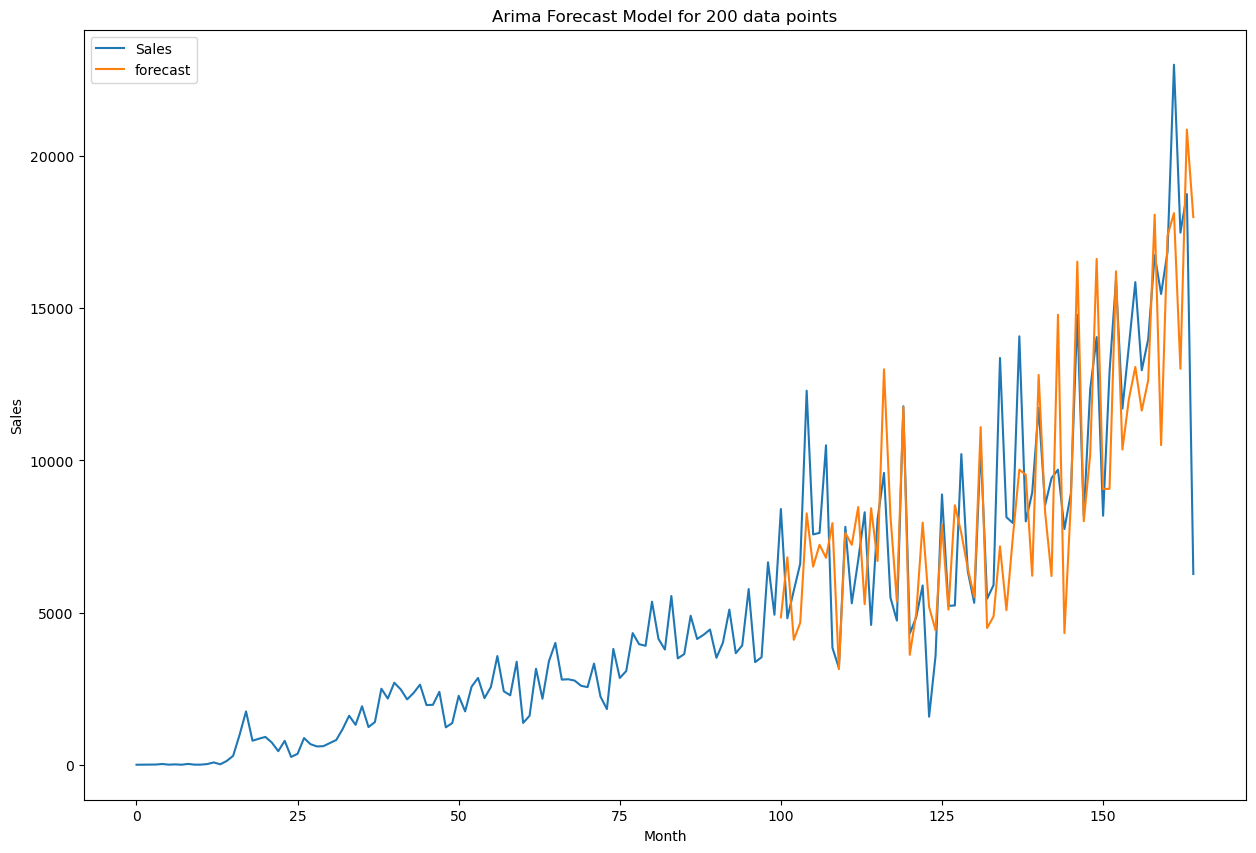

In [27]:
# Using Arima model
#Start forecast at a range of 100 and end at 200 for atleast a data point of 200
start = 100
end= 200

data['forecast'] = results.predict(start = 100, end= 200)  
data[['Sales', 'forecast']].plot(figsize=(15, 10))
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Arima Forecast Model for 200 data points')



In [28]:
# Compute ther Mean Squared Error of the Forecasts
#MSE= 8,415,238.58

mse = ((data['Sales'] - data['forecast']) ** 2).mean()


print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))


The Mean Squared Error of our forecasts is 8415238.58


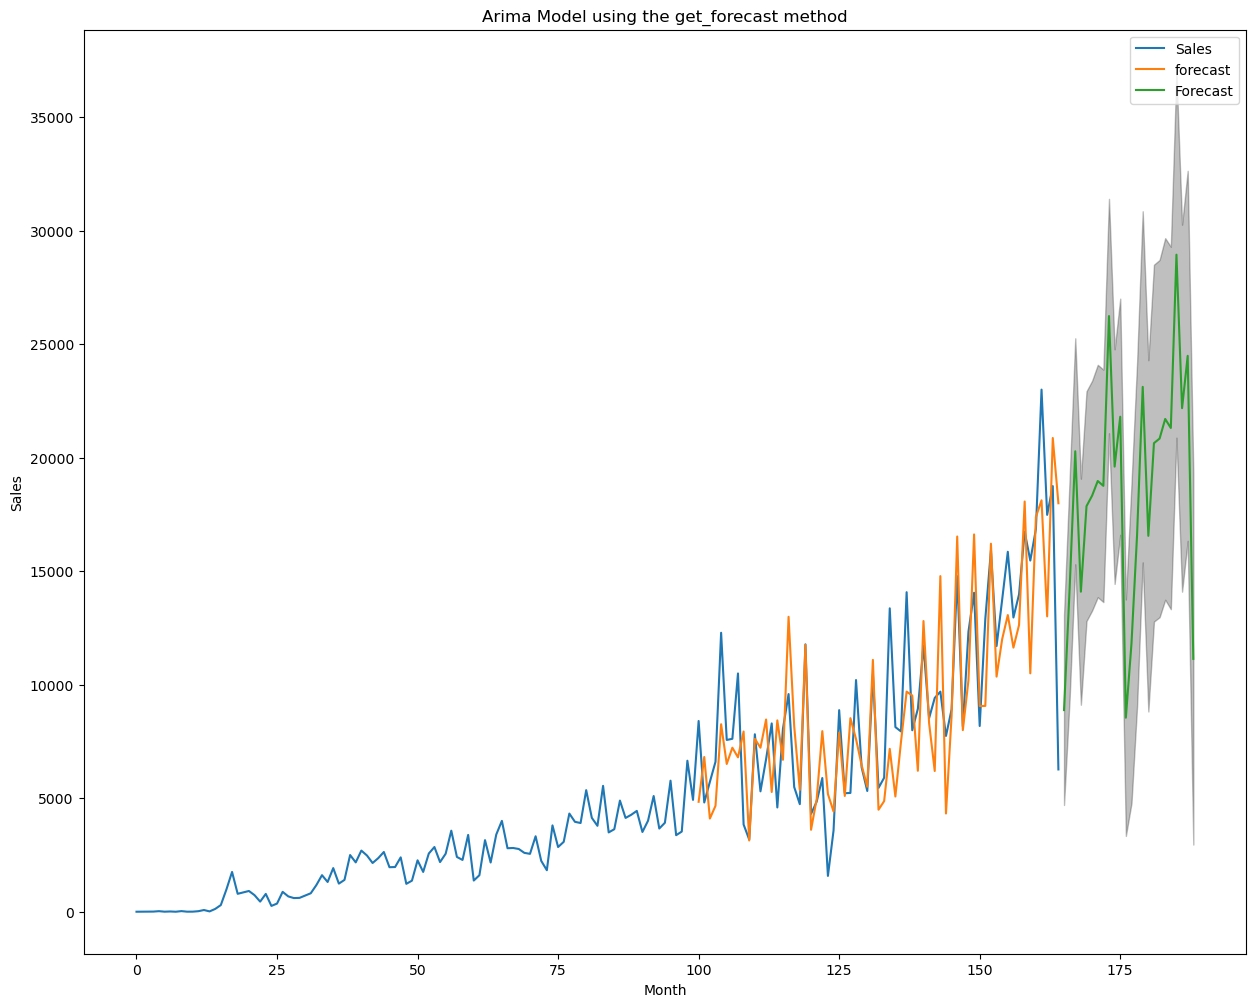

In [29]:
# Use the ARIMA model to forecast the future

# Set the number of periods for forecasting
periods = 24


# Get the forecast for the next 'periods' steps
pred_uc = results.get_forecast(steps=periods)

# Calculate the confidence intervals for the forecast
pred_ci = pred_uc.conf_int()


# Plot the observed data
ax = data.plot(label='observed', figsize=(15, 12))

# Plot the forecasted mean
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')

# Fill the area between the upper and lower confidence intervals
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Month')
ax.set_ylabel('Sales')
ax.set_title('Arima Model using the get_forecast method')
plt.legend()
plt.show()


In [30]:
# Forecast using Prophet

data['ds'] = pd.to_datetime(data['Month'])
data['y'] = data['Sales']

data2 = data[['ds', 'y']]

data2.head()

,ds,y
0,2008-10-01,3
1,2010-01-01,4
2,2010-02-01,5
3,2010-03-01,9
4,2010-04-01,27


21:27:52 - cmdstanpy - INFO - Chain [1] start processing
21:27:52 - cmdstanpy - INFO - Chain [1] done processing


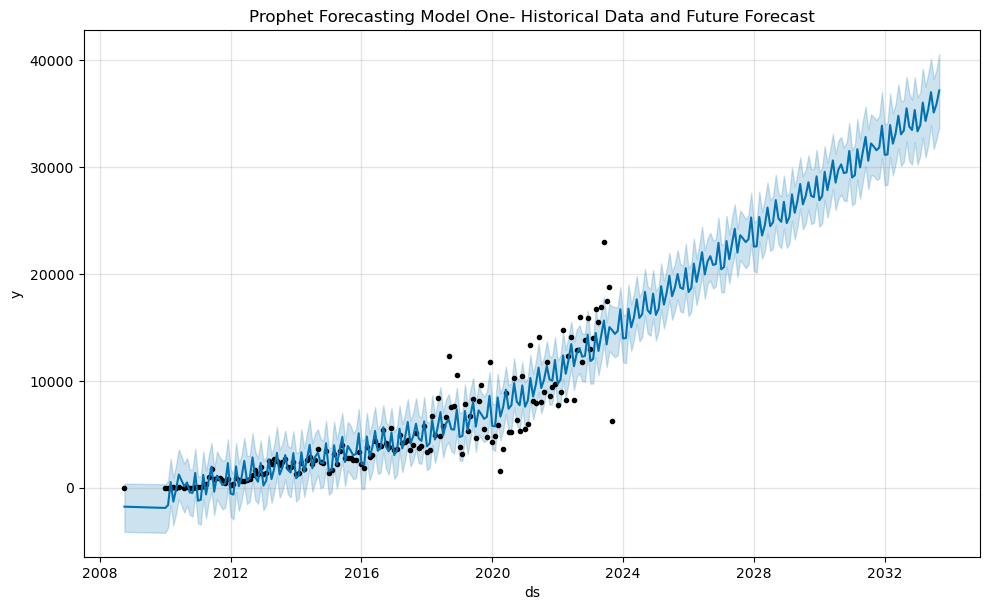

MAE: 1186.416


In [31]:
model = Prophet()

model.fit(data2)

future = model.make_future_dataframe(periods=120, freq='MS')

forecast = model.predict(future)

model.plot(forecast);
plt.title('Prophet Forecasting Model One- Historical Data and Future Forecast')
plt.show()
y_true = data2['y'].values
y_pred = forecast['yhat'][:len(y_true)].values
mae = abs(y_true - y_pred).mean()
print('MAE: %.3f' % mae)


21:27:53 - cmdstanpy - INFO - Chain [1] start processing
21:27:53 - cmdstanpy - INFO - Chain [1] done processing
21:27:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:27:53 - cmdstanpy - INFO - Chain [1] start processing
21:27:54 - cmdstanpy - INFO - Chain [1] done processing


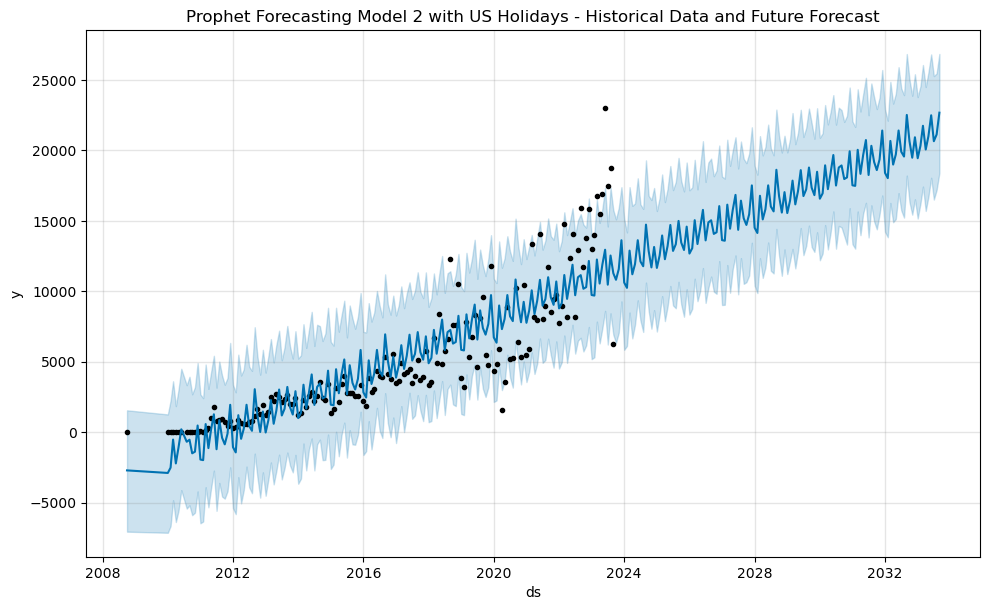

MAE: 1561.893


In [32]:
model2 = Prophet(interval_width=0.95, yearly_seasonality=True, weekly_seasonality=False, changepoint_prior_scale=0.001)

model2.add_country_holidays(country_name='US')

model2.fit(data2)

future = model2.make_future_dataframe(periods=120, freq='MS')

forecast = model2.predict(future)

model2.plot(forecast);
plt.title('Prophet Forecasting Model 2 with US Holidays - Historical Data and Future Forecast')
plt.show()

y_true = data2['y'].values
y_pred = forecast['yhat'][:len(y_true)].values
mae = abs(y_true - y_pred).mean()
print('MAE: %.3f' % mae)


21:27:54 - cmdstanpy - INFO - Chain [1] start processing
21:27:54 - cmdstanpy - INFO - Chain [1] done processing


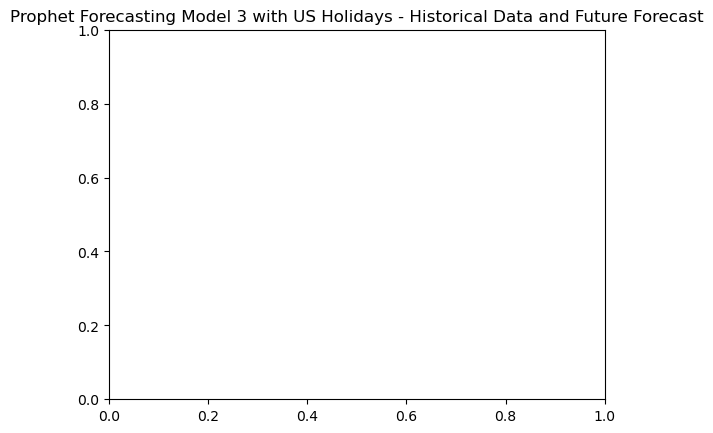

MAE: 1125.607


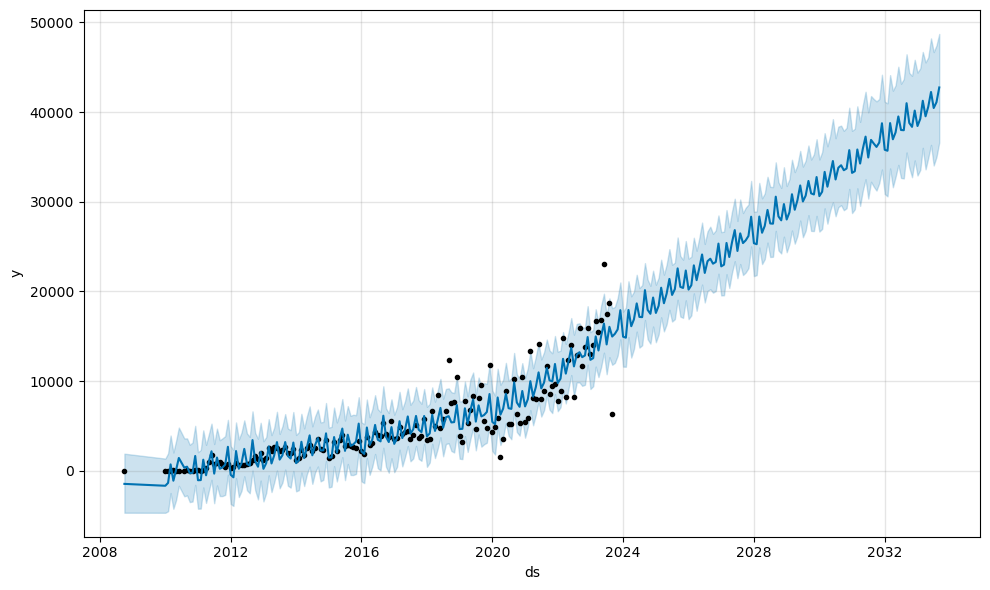

In [33]:
model3 = Prophet(interval_width=0.95, yearly_seasonality=True, weekly_seasonality=False, changepoint_prior_scale=0.1)

model3.add_country_holidays(country_name='US')

model3.fit(data2)

future = model3.make_future_dataframe(periods=120, freq='MS')

forecast = model3.predict(future)
plt.title('Prophet Forecasting Model 3 with US Holidays - Historical Data and Future Forecast')
plt.show()


model3.plot(forecast);

y_true = data2['y'].values
y_pred = forecast['yhat'][:len(y_true)].values
mae = abs(y_true - y_pred).mean()
print('MAE: %.3f' % mae)


In [34]:
# Use Optimization Library to Find Optimal Parameters

data['ds']= pd.to_datetime(data['Month'])
data['y']= data['Sales']

data2 = data[['ds', 'y']]

# 
data2['cap'] = 50000
data2['floor'] = 1000

data2

C:\Users\user\AppData\Local\Temp\ipykernel_1780\1143393053.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['cap'] = 50000
C:\Users\user\AppData\Local\Temp\ipykernel_1780\1143393053.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['floor'] = 1000


,ds,y,cap,floor
0,2008-10-01,3,50000,1000
1,2010-01-01,4,50000,1000
2,2010-02-01,5,50000,1000
3,2010-03-01,9,50000,1000
4,2010-04-01,27,50000,1000
...,...,...,...,...
160,2023-05-01,16860,50000,1000
161,2023-06-01,23005,50000,1000
162,2023-07-01,17487,50000,1000
163,2023-08-01,18754,50000,1000


In [35]:


train_df, test_df = np.split(data2, [int(0.7 *len(data2))]) 

len(data2), len(train_df), len(test_df)


(165, 115, 50)

In [36]:
# set up the objective function 

def objective(trial):
    
    params = {
        'weekly_seasonality': trial.suggest_int('weekly_seasonality', 5, 10),
        'yearly_seasonality': trial.suggest_int('yearly_seasonality', 1, 20),
        'seasonality_mode': trial.suggest_categorical('seasonality_mode', ['multiplicative', 'additive']),
        'holidays_prior_scale': trial.suggest_float('holidays_prior_scale', 0.1, 10),
        'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
        'seasonality_prior_scale': trial.suggest_float('seasonality_prior_scale', 0.1, 10),
    }
    
    # you may explore other parameters in prophet if time allows
    # you may also explore specific holidays to include if time allows
    # see https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html#built-in-country-holidays

    m = Prophet(**params)  #define the prophet model
    m.add_country_holidays(country_name='US') 
    m.fit(train_df) 
    preds = m.predict(test_df[['ds', 'cap', 'floor']])

    mape_score = mean_absolute_percentage_error(test_df['y'], preds['yhat'])
    
    return mape_score

study = optuna.create_study(direction = 'minimize') 

study.optimize(objective, n_trials = 20)

print(study.optimize)

[I 2023-12-14 21:27:55,195] A new study created in memory with name: no-name-556ae582-56dd-41ae-9912-aadd3819fd18
21:27:55 - cmdstanpy - INFO - Chain [1] start processing
21:27:55 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-12-14 21:27:55,537] Trial 0 finished with value: 0.4214229982257762 and parameters: {'weekly_seasonality': 10, 'yearly_seasonality': 2, 'seasonality_mode': 'additive', 'holidays_prior_scale': 8.052342106633912, 'growth': 'logistic', 'changepoint_prior_scale': 2.988628713968211, 'seasonality_prior_scale': 6.009525686471898}. Best is trial 0 with value: 0.4214229982257762.
21:27:55 - cmdstanpy - INFO - Chain [1] start processing
21:27:55 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-12-14 21:27:55,810] Trial 1 finished with value: 0.42096523677527486 and parameters: {'weekly_seasonality': 5, 'yearly_seasonality': 5, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 7.7981961476314545, 'growth': 'linear', 'changepoint_prior_scale': 0.662

[I 2023-12-14 21:28:00,696] Trial 16 finished with value: 0.6751440814633183 and parameters: {'weekly_seasonality': 9, 'yearly_seasonality': 14, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 6.452849501701078, 'growth': 'linear', 'changepoint_prior_scale': 1.7490035698696824, 'seasonality_prior_scale': 0.4902906976349988}. Best is trial 4 with value: 0.33661345108845336.
21:28:00 - cmdstanpy - INFO - Chain [1] start processing
21:28:00 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-12-14 21:28:00,977] Trial 17 finished with value: 0.3495022856332832 and parameters: {'weekly_seasonality': 8, 'yearly_seasonality': 18, 'seasonality_mode': 'additive', 'holidays_prior_scale': 8.847481676154505, 'growth': 'linear', 'changepoint_prior_scale': 0.05485536345457552, 'seasonality_prior_scale': 1.8435120671256264}. Best is trial 4 with value: 0.33661345108845336.
21:28:01 - cmdstanpy - INFO - Chain [1] start processing
21:28:01 - cmdstanpy - INFO - Chain [1] done processing

<bound method Study.optimize of <optuna.study.study.Study object at 0x00000211BE58A810>>


21:29:03 - cmdstanpy - INFO - Chain [1] start processing
21:35:41 - cmdstanpy - INFO - Chain [1] done processing


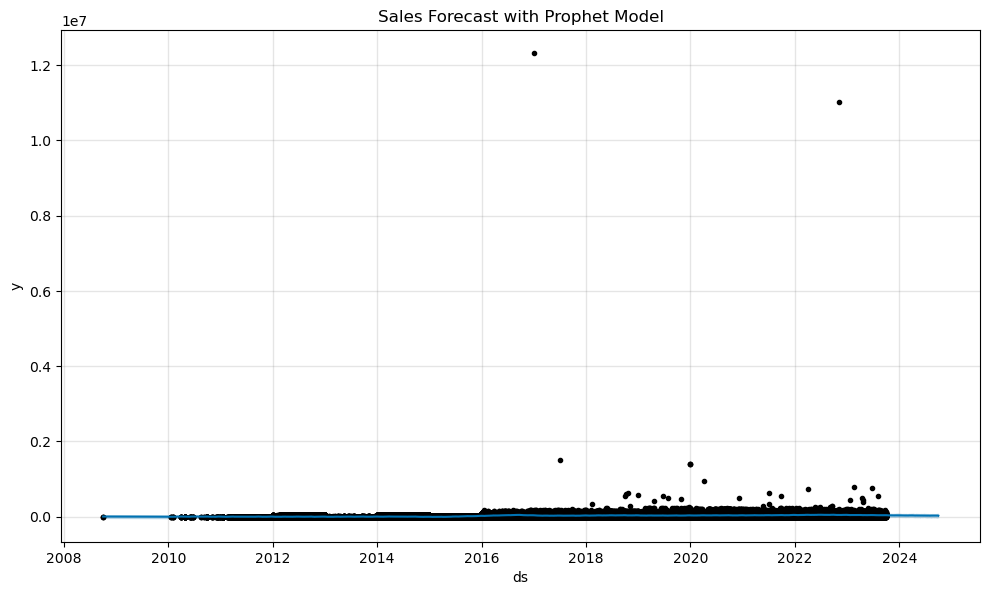

In [37]:


df['Sale Date'] = pd.to_datetime(df['Sale Date'])
data = df[['Sale Date', 'Sale Price']].rename(columns={'Sale Date': 'ds', 'Sale Price': 'y'})
model = Prophet()
model.fit(data)
future = model.make_future_dataframe(periods=365)  # Adjust the number of periods as needed
forecast = model.predict(future)
fig = model.plot(forecast)
plt.title('Sales Forecast with Prophet Model')
plt.show()




In [ ]:


# Convert 'Sale Date' to datetime
df['Sale Date'] = pd.to_datetime(df['Sale Date'])

# Prepare data for Prophet
data = df[['Sale Date', 'Sale Price']].rename(columns={'Sale Date': 'ds', 'Sale Price': 'y'})

# Initialize and fit the Prophet model
model = Prophet()
model.fit(data)

# Create a future DataFrame for prediction
future = model.make_future_dataframe(periods=365)  # Adjust the number of periods as needed

# Generate forecast
forecast = model.predict(future)

# Plot the forecast
fig = model.plot(forecast)

# Set y-axis limits for better visibility
plt.ylim(bottom=15)  # You can adjust the bottom value as needed



# Set title
plt.title('Sales Forecast with Prophet Model')

# Show the plot
plt.show()


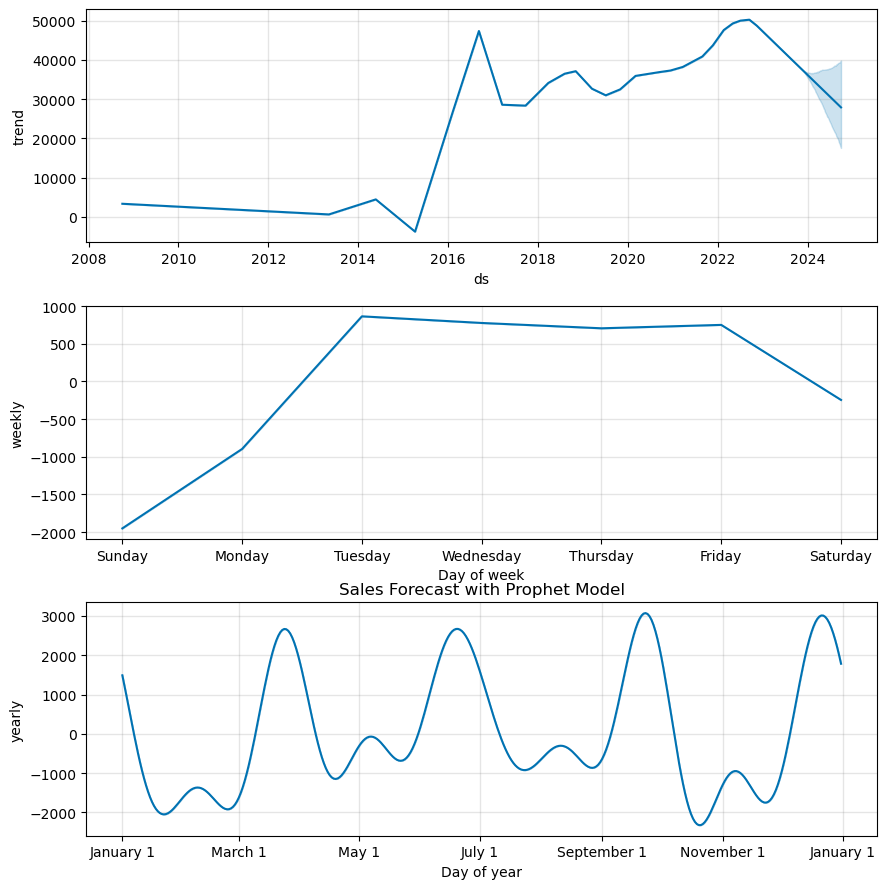

In [38]:
fig = model.plot_components(forecast)
plt.title('Sales Forecast with Prophet Model')
plt.show()

In [39]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]



,ds,yhat,yhat_lower,yhat_upper
0,2008-10-02,5618.129719,-29972.078982,41571.688739
1,2010-01-18,-255.233754,-38726.889215,37094.090870
2,2010-02-01,-1.785306,-37654.033920,37449.442600
3,2010-03-27,4747.272777,-31105.436040,41828.500708
4,2010-03-30,5494.367173,-32224.580934,43519.960771
...,...,...,...,...
4914,2024-09-25,31746.004281,-10600.105680,75412.477643
4915,2024-09-26,31542.743907,-7300.393205,70546.993999
4916,2024-09-27,31420.973379,-11077.085218,74652.518422
4917,2024-09-28,30225.010888,-10643.899833,67577.424295


Mean Squared Error: 736468890.7634056


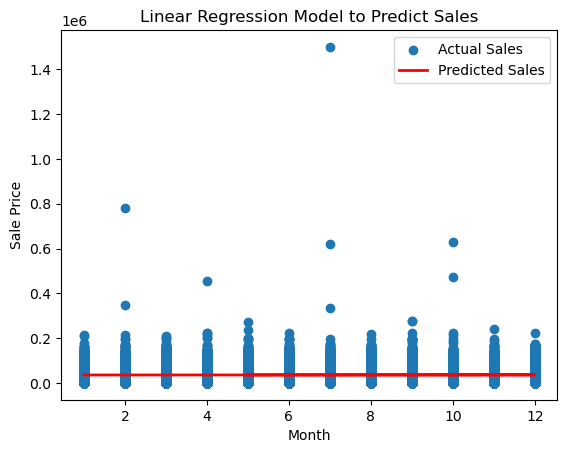

In [40]:


# Convert 'Sale Date' to datetime and extract month
df['Sale Date'] = pd.to_datetime(df['Sale Date'])
df['Month'] = df['Sale Date'].dt.month

# Assuming 'Sale Price' is the dependent variable (y) and 'Month' is the independent variable (X)
X = df[['Month']]
y = df['Sale Price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a linear regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Visualize predictions vs. actual values
plt.scatter(X_test, y_test, label='Actual Sales')
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Predicted Sales')
plt.xlabel('Month')
plt.ylabel('Sale Price')
plt.title('Linear Regression Model to Predict Sales')
plt.legend()
plt.show()


Accuracy: 0.7532024321661179
Confusion Matrix:
[[107715   8270]
 [ 32806  17645]]


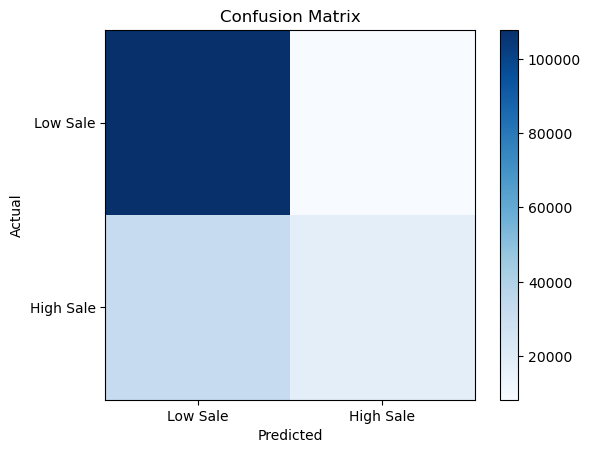

In [41]:
# Logistic Regression

# Create a binary outcome variable (1 if Sale Price is above a threshold, 0 otherwise)
threshold = 50000
df['SaleOutcome'] = (df['Sale Price'] > threshold).astype(int)

# Convert 'Sale Date' to datetime and extract month
df['Sale Date'] = pd.to_datetime(df['Sale Date'])
df['Month'] = df['Sale Date'].dt.month

# Define features and target variable
X = df[['Month', 'Electric Range', 'Odometer Reading', 'Base MSRP', 'Transaction Year',
        'Clean Alternative Fuel Vehicle Type', 'Make', 'Vehicle Primary Use']]
y = df['SaleOutcome']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a column transformer to handle categorical variables
categorical_cols = ['Clean Alternative Fuel Vehicle Type', 'Make', 'Vehicle Primary Use']
numeric_cols = ['Month', 'Electric Range', 'Odometer Reading', 'Base MSRP', 'Transaction Year']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ])

# Create a logistic regression model pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)

# Visualize confusion matrix
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0, 1], ['Low Sale', 'High Sale'])
plt.yticks([0, 1], ['Low Sale', 'High Sale'])
plt.show()
